# Image Super-resolution with Deep Image Prior

LS2N-SIMS - Ecole Centrale de Nantes

Supervisor: **Diana Mateus**

Student: **Wenrui Li**

### Introduction

In this notebook we will approache the image super-resolution (SR) problem by means of Deep Image Prior (DIP).

DIP was first proposed by Ulyanov et al. in 2018.

Refer to their website: https://dmitryulyanov.github.io/deep_image_prior

### 1. Load modules and data

#### 1.1 Import modules

In [3]:
#4S
# Import all the necessary libraries
import os
import datetime 
import glob                                           #filename pattern matching
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

#SKIMAGE
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
import skimage.exposure                               #Used for displaying 

#Keras and related modules
import keras
from keras import backend as K                        #https://keras.io/backend/
import tensorflow as tf

#Layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Lambda                       #Lambda wraps arbitrary expression as a Layer object.
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import add, concatenate
from keras import regularizers
from keras.initializers import he_normal, glorot_normal, he_uniform, glorot_uniform

#To save and reload models, to modify model parameters by callbacks
from keras.models import load_model, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.utils import multi_gpu_model, plot_model

#For data augmentation
from keras.preprocessing.image import ImageDataGenerator    

#Sklearn 
import sklearn
from sklearn.model_selection import train_test_split

#Scipy
#import scipy.misc

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)
#print('Scipy        :', scipy.__version__)

Python       : 3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:05:27) [MSC v.1900 64 bit (AMD64)]
Numpy        : 1.15.2
Skimage      : 0.14.2
Scikit-learn : 0.20.0
Keras        : 2.2.4
Tensorflow   : 1.12.0


#### 1.2 Define global parameters
- Define the SR factor
- Define the HR image size``` img_height, img_width ```
- Define the stride for cropping HR images from original images
- Define the number of color channels, 1 for gray images and Y channel images, 3 for RGB images

In [5]:
#4S

# Set number of GPUs
num_gpus = 1   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set the SR factor, usually 2, 3, 4 or 8
SR_factor = 4

# Set height (y-axis length) and width (x-axis length) of HR image
img_height, img_width = (192,192) if SR_factor == 3 else (256,256)

# Set stride for cutting images
cut_stride = img_height

# Set number of color channels
chan_num = 3

#### 1.3 Import data 

#### 1.3.1 Define the data path
Define the data path and change the directory to the defined topDir.

In [6]:
#4S
topDir = "." 
os.chdir(topDir)    
print(os.listdir(os.path.join(topDir, 'input')))  #see what's in the input folder (where data is in)
test_path = os.path.join(topDir, 'input/test/Set5')   #path to test data file/folder

['test', 'train']


#### 1.3.2 Read and preload the HR image data
Read the data and create a tensor containing all the ground truth images (HR images).

Create a function ``get_HR_images`` that 
- receives as input an image path.
- lists all files in the input image path. Hint: use ``os.listdir``.
- reads each of the files with ``skimage.io.imread`` or ``skimage.io.ImageCollection``
- default setting is implementing SR on RGB channels simultaneously
- if SR is only implemented in Y channel, transfer RGB to YCbCr, store them respectively and return them as numpy arrays.
- cut images into predefined size ``(img_height, img_width)`` with predefined stride ``cut_stride``.
- use ``%%time`` to display the time spent in loading.
- Run the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3) uint8 or float64

In [8]:
def modcrop(image, scale=SR_factor):
    if len(image.shape) == 3: # 3 channel image
        h, w, _ = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]
    else:  # 1 channel image
        h, w = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w]
    return image

In [9]:
%%time
# Get HR data in RGB form
def get_HR_images(path):
    
    HR_img = []
    
    #Loads images from path/{id}.jpg into a numpy array
    files_list = os.listdir(path)
    files_list.sort(key = lambda x:x[:-4])
    img_paths = ['{0}/{1}'.format(path, id) for id in files_list]
    
    ic = skimage.io.ImageCollection(load_pattern=img_paths)
    
    for im in ic:
        im = modcrop(im, SR_factor)
        (h,w,c) = im.shape
        for x in range(0,h-img_height+1,cut_stride):
                    for y in range(0,w-img_width+1,cut_stride):
                                im_full = im[x : x+img_height, y : y+img_width,:]
                                HR_img.append(im_full)
    
    HR_img = np.array(HR_img)
    
    return HR_img

HR_test = get_HR_images(test_path)
print('HR test images:', HR_test.shape, HR_test.dtype)

HR test images: (7, 256, 256, 3) uint8
Wall time: 322 ms


#### 1.3.3 Process the HR image data to acquire LR images (used as labels)
Create a tensor containing all the LR images.

Create a function ``get_LR_images`` that
- receives as input a HR image array (can be train or test)
- downsample the images with bicubic interpolation. 
- implement bicubic interpolation to upscale the LR image to the size of the HR ones.
- return a numpy array (matrix) .
- use ``%%time`` to display the time spent in loading.
- Run the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3) uint8 or float64

In [10]:
%%time
# Get LR data
def get_LR_images(HR_data):
    
    LR_dsp = [] # store down-sampled images
    LR_bic = [] # store up-scaled images
    
    for i in range(HR_data.shape[0]):
        im_i = HR_data[i,:,:,:] # Acquire one image
        
        # downsampling, order = 3 -> bicubic, anti_aliasing = True -> implement Gaussian blurring
        downsampled_i = skimage.transform.rescale(im_i, scale=1/SR_factor, order=3, mode='reflect', cval=0, clip=True, 
                                preserve_range=False, multichannel=True, anti_aliasing=True, anti_aliasing_sigma=None)
        
        #bicubic interpolation
        interpolated_i = skimage.transform.rescale(downsampled_i, scale=SR_factor, order=3, mode='reflect', cval=0, clip=True, 
                                preserve_range=False, multichannel=True, anti_aliasing=True, anti_aliasing_sigma=None)
        
        LR_dsp.append(downsampled_i)
        LR_bic.append(interpolated_i)

    LR_dsp = np.array(LR_dsp)
    LR_bic = np.array(LR_bic)
    #LR_img = LR_img.reshape(LR_img.shape[0],LR_img.shape[1],LR_img.shape[2],chan_num)
    return LR_dsp,LR_bic

LR_test,LR_test_bic = get_LR_images(HR_test)
print('LR test images:', LR_test.shape, LR_test.dtype)
print('upscaled test images:', LR_test_bic.shape, LR_test_bic.dtype)

# make sure pixel values are normalized to [0,1]
print(np.min(LR_test),np.max(LR_test))
print(np.min(LR_test_bic),np.max(LR_test_bic))

LR test images: (7, 64, 64, 3) float64
upscaled test images: (7, 256, 256, 3) float64
0.0 1.0
0.0 1.0
Wall time: 437 ms


#### Normalize HR images

In [11]:
HR_test = HR_test/255.0

print(np.min(HR_test),np.max(HR_test))

0.0 1.0


#### 1.4 Visualize some examples of images and matching labels
Choose one index among the list and use ``plt.imshow`` to visualize side by side the corresponding HR image and LR image.

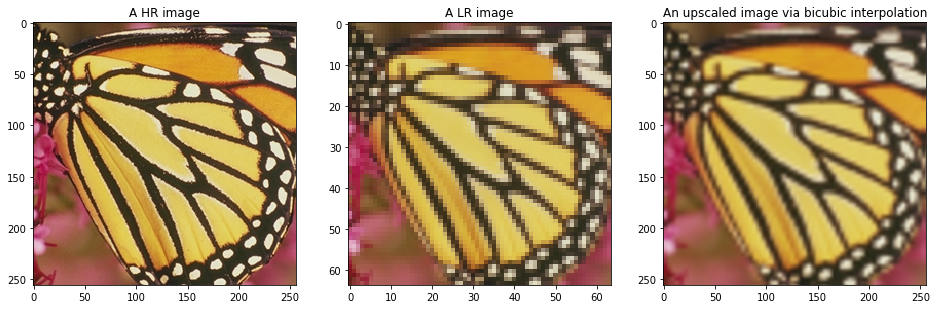

In [27]:
# Choose an image
ind = 5

HR_ex = HR_test[ind,:,:,:]

LR_ex = LR_test[ind,:,:,:]

LR_bic_ex = LR_test_bic[ind,:,:,:]

plt.rcParams['figure.figsize']=(16,6)
plt.figure()
plt.subplot(131)
plt.imshow(HR_ex)
plt.title("A HR image")
plt.subplot(132)
plt.imshow(LR_ex)
plt.title("A LR image")
plt.subplot(133)
plt.imshow(LR_bic_ex)
plt.title("An upscaled image via bicubic interpolation")
plt.show()

### 2. Buidling the DIP model
#### 2.1. Define the parameters and the architecture

#### 2.1.1 Set options

In [28]:
# Define options for model
param_activ_func = 0.2       #0 for relu, 0.2 for leaky relu

#Whether to perturb input with additive noise
reg_noise_std = 0.03 # standard deviation of the additive noise

# Options for training
init = 'GlorotUni' # 'GlorotUni', 'HeUni', GlorotNorm' or 'HeNorm'
optim = 'Adam' # Choose optimizer
lr_decay = False # whether use learning rate decay or not
lr_init = 0.01 #Initial learning rate

#### 2.1.2 Define network architecture

In [29]:
# wrap downsampling operation as a layer
def Downsampler(img):
    img_dsp = tf.image.resize_images(img,(img_height//SR_factor,img_width//SR_factor),method=tf.image.ResizeMethod.BICUBIC)
    return img_dsp

# Design our model architecture here
def dip_model(img_width=256, img_height=256):
    
    #define the architecture parameters
    n_channels = [128,128,128,128,128]  #the number of kernels per downsampling and upsampling block
    n_channels_skip = [4,4,4,4,4]       #the number of kernels per skip connection block
    k_size = (3,3)                      #size of kernels in downsampling and upsampling blocks
    k_size_skip = (1,1)                 #size of kernels in skip connection blocks
    
    if init == 'HeNorm':
        k_init = he_normal()
    elif init == 'GlorotNorm':
        k_init = glorot_normal()
    elif init == 'HeUni':
        k_init = he_uniform()
    else:
        k_init = glorot_uniform()
    
    # Use Keras Input layer to create one
    inp = Input((img_width, img_height,32)) # Input is a 3D tensor with 32 channels
    
    # Encoder
    enc=[]
    
    for i in range(len(n_channels)):
        if i==0:
            activ2 = inp
        
        # Convolutional Layer #1
        conv1 = Conv2D(filters=n_channels[i], kernel_size=k_size, strides=2, padding="same", data_format="channels_last",
                       activation=None, kernel_initializer=k_init)(activ2)
        
        # Batch normailization
        bn1 = BatchNormalization(axis=-1)(conv1)
        
        # Activation
        activ1 = Activation('relu')(bn1) if param_activ_func == 0 else LeakyReLU(alpha = param_activ_func)(bn1)
        
        # Convolutional Layer #2
        conv2 = Conv2D(filters=n_channels[i], kernel_size=k_size, strides=1, padding="same", data_format="channels_last",
                       activation=None, kernel_initializer=k_init)(activ1)
        
        # Batch normailization
        bn2 = BatchNormalization(axis=-1)(conv2)
        
        # Activation
        activ2 = Activation('relu')(bn2) if param_activ_func == 0 else LeakyReLU(alpha = param_activ_func)(bn2)
        
        #Add output of this block to the encoder blocks list
        enc.append(activ2)

    # Decoder
    
    for i in range(len(n_channels)-1, -1, -1):
        # Convolutional Layer in skip connection
        conv_skip = Conv2D(filters=n_channels_skip[i], kernel_size=k_size_skip, strides=1, padding="same", data_format="channels_last",
                       activation=None, kernel_initializer=k_init)(enc[i])
        
        bn_skip = BatchNormalization(axis=-1)(conv_skip)
        
        act_skip = Activation('relu')(bn_skip) if param_activ_func == 0 else LeakyReLU(alpha = param_activ_func)(bn_skip)
        
        # Concatenating
        if i == len(n_channels)-1:
            conca = act_skip
        else:
            conca = concatenate([act_skip,up])
        
        bn = BatchNormalization(axis=-1)(conca)
        
        # Convolutional Layer #1
        conv1 = Conv2D(filters=n_channels[i], kernel_size=k_size, padding="same", data_format="channels_last",
                       activation=None, kernel_initializer=k_init)(bn)
        
        bn1 = BatchNormalization(axis=-1)(conv1)
        
        # Activation
        activ1 = Activation('relu')(bn1) if param_activ_func == 0 else LeakyReLU(alpha = param_activ_func)(bn1)
        
        # Convolutional Layer #2
        conv2 = Conv2D(filters=n_channels[i], kernel_size=(1,1), padding="same", data_format="channels_last",
                       activation=None, kernel_initializer=k_init)(activ1)
        
        bn2 = BatchNormalization(axis=-1)(conv2)
        
        # Activation
        activ2 = Activation('relu')(bn2) if param_activ_func == 0 else LeakyReLU(alpha = param_activ_func)(bn2)
        
        # Upsampling
        up = UpSampling2D(size=(2, 2), data_format="channels_last", interpolation='bilinear')(activ2)
        # Transpose convolution can also be used to upsample
        #up = Conv2DTranspose(filters=n_channels[i], kernel_size=(2,2), strides=2, padding="same", data_format="channels_last",
        #                     activation=None, kernel_initializer=k_init)(activ2)
        
    # Output
    hr_outp = Conv2D(filters=chan_num, kernel_size=(1,1), strides=1, padding="same", data_format="channels_last",
                  activation='sigmoid', kernel_initializer=k_init,name='hr_outp')(up)
    
    lr_outp = Lambda(Downsampler,name='lr_outp')(hr_outp)
    
    #Build Model with the architecture
    model = Model(inputs=[inp], outputs=[hr_outp,lr_outp])
    return model

#### 2.2. Define the losses and metrics

In [30]:
#MSE loss
def mse_loss(hr_img, sr_img):
    mse=K.mean(K.abs(hr_img-sr_img)**2)
    return mse

#Compute log10
def log10(x):
    numerator = K.log(x)
    denominator = K.log(K.constant(10, dtype=numerator.dtype))
    return numerator / denominator

#PSNR metric
def psnr(hr_img, sr_img):
    psnr = 20 * log10(1.0 / K.sqrt(mse_loss(hr_img, sr_img)))
    return psnr

#SSIM metric
def ssim(hr_img, sr_img):
    mu_h = K.mean(hr_img)
    mu_s = K.mean(sr_img)
    sig_h = K.std(hr_img)
    sig_s = K.std(sr_img)
    cov_hs = K.mean((hr_img-mu_h) * (sr_img-mu_s))
    
    c1 = 0.01**2
    c2 = 0.03**2
    
    ssim = (2*mu_h*mu_s + c1)*(2*cov_hs + c2)/(mu_h**2 + mu_s**2 + c1)/(sig_h**2 + sig_s**2 + c2)
    return ssim

#### 2.3 Define optimizer 

In [31]:
# Set some model compile parameters
optimizer = keras.optimizers.SGD(lr=lr_init,momentum=0.9) if optim == 'SGD' else keras.optimizers.Adam(lr=lr_init)
loss      = 'mean_squared_error'#mse_loss #"mean_absolute_error"
metrics   = {'hr_outp':[psnr,ssim],'lr_outp':[psnr,ssim]}#[psnr,ssim]

#### 2.4 Compile the model

In [32]:
# Compile the model and list its structure
model = dip_model(img_width, img_height)
model.summary()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=[0.0,1.0])
# loss_weights indicate that only LR output is use to compute loss

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 32) 0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 128, 128, 128 36992       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 128, 128, 128 512         conv2d_26[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_26 (LeakyReLU)      (None, 128, 128, 128 0           batch_normalization_31[0][0]     
__________________________________________________________________________________________________
conv2d_27 

### 3. Training

#### 3.1 Train with visualization of the losses

In [33]:
# Define save name
path1 = '_Factor' + str(SR_factor)
path2 = '_CleanInput' if reg_noise_std == 0 else '_PerturbedInput'
path3 = '_' + init
path4 = '_Relu' if param_activ_func == 0 else '_LeakyRelu'
path5 = '_LRDecay' if lr_decay == True else '_LRFixed'+str(lr_init)

savename = path1 + path2 + path3 + path4 + path5

In [34]:
#4S
# Runtime custom callbacks for loss visualization
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from IPython.display import clear_output
#from matplotlib.ticker import FormatStrFormatter

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Loss", 'psnr': "PSNR(dB)", 'ssim': "SSIM", 'mse_loss': "Loss"}
    if x in translations:
        return translations[x]
    else:
        return x

class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.LR = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())
        self.LR.append(K.get_value(self.model.optimizer.lr))
        
        metric_dir = "./DIP_saved_model" + savename
        metric_path = 'metrics' + savename + '.svg'

        if not os.path.isdir(metric_dir):
            os.makedirs(metric_dir)

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        plt.subplot(2,2,1)
        plt.grid()
        plt.plot(range(1, len(self.logs) + 1),[log['lr_outp_loss'] for log in self.logs],marker="o", label="LR output")
        plt.plot(range(1, len(self.logs) + 1),[log['hr_outp_loss'] for log in self.logs],marker="o", label="HR output")
        plt.title('Loss')
        plt.xlabel('epoch')
        plt.legend(loc='center right')
        
        plt.subplot(2,2,2)
        plt.grid()
        plt.plot(range(1, len(self.logs) + 1),[log['lr_outp_psnr'] for log in self.logs],marker="o", label="LR output")
        plt.plot(range(1, len(self.logs) + 1),[log['hr_outp_psnr'] for log in self.logs],marker="o", label="HR output")
        plt.title('PSNR(dB)')
        plt.xlabel('epoch')
        plt.legend(loc='center right')
        
        plt.subplot(2,2,3)
        plt.grid()
        plt.plot(range(1, len(self.logs) + 1),[log['lr_outp_ssim'] for log in self.logs],marker="o", label="LR output")
        plt.plot(range(1, len(self.logs) + 1),[log['hr_outp_ssim'] for log in self.logs],marker="o", label="HR output")
        plt.title('SSIM')
        plt.xlabel('epoch')
        plt.legend(loc='center right')
            
        plt.subplot(2,2,4)
        plt.grid()
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.plot(range(1, len(self.logs) + 1),self.LR,marker="o")
        plt.title('Learning rate')
        plt.xlabel('epoch')
        
        plt.tight_layout()
        plt.savefig(os.path.join(metric_dir, metric_path),format='svg', dpi=1200)
        plt.show();
        
        
        
        # illustrate network output every 100 iterations
        if (epoch+1) % 100 == 0:
            result_dir = "./DIP_saved_model" + savename + "/SR_result_on_epoch_end"
            result_path = 'SR_result_epoch' + str(epoch+1) + savename + '.svg'
            
            if not os.path.isdir(result_dir):
                os.makedirs(result_dir)
            
            inp = self.model.input
            sr_out = self.model.layers[-2].output
            lr_out = self.model.layers[-1].output
            functors = K.function([inp,K.learning_phase()], [sr_out,lr_out])
            layer_outs = functors([z,1])
            hr_out = layer_outs[0].reshape((img_height,img_width,chan_num))
            lr_out = layer_outs[1].reshape((img_height//SR_factor,img_width//SR_factor,chan_num))
            
            plt.figure(figsize=(8,8))
            plt.subplot(221)
            plt.imshow(hr_out)
            plt.title("Network HR output on iteration " + str(epoch+1) + "/{0:.2f}dB/{1:.4f}".format(self.logs[epoch]['hr_outp_psnr'],self.logs[epoch]['hr_outp_ssim']))
            plt.subplot(222)
            plt.imshow(HR_test[ind,:,:,:])
            plt.title("Ground truth")
            plt.subplot(223)
            plt.imshow(lr_out)
            plt.title("Network LR output on iteration " + str(epoch+1) + "/{0:.2f}dB/{1:.4f}".format(self.logs[epoch]['lr_outp_psnr'],self.logs[epoch]['lr_outp_ssim']))
            plt.subplot(224)
            plt.imshow(LR_test[ind,:,:,:])
            plt.title("LR image to be fitted")
            plt.savefig(os.path.join(result_dir, result_path), format='svg',dpi=1200)
            plt.show()
        
plot_losses = PlotLosses(figsize=(12.8,8))

#### 3.2 Launch the training
- Use the model.fit function, and  
- save the final model. 
- Measure the overall time.


#### 3.2.1 Generate input and select one image

In [35]:
def get_input(reg_noise_std):
    size = (1,img_height,img_width,32)
    np.random.seed(42) # seed must be set, as input is fixed thoroughout the optimization; use different seed to change input
    input_z = np.random.uniform(0.0,0.1,size)
    # perturb input
    if reg_noise_std != 0:
        np.random.seed() # cancel the seed above to generate random values every iteration
        input_z = input_z + np.random.normal(0.0,reg_noise_std,size)
    return input_z

def get_label(ind):
    label_lr = LR_test[ind,:,:,:]
    (h,w,c) = label_lr.shape
    label_lr = label_lr.reshape((1,h,w,c))
    
    label_hr = HR_test[ind,:,:,:]
    (h,w,c) = label_hr.shape
    label_hr = label_hr.reshape((1,h,w,c))
    return label_lr,label_hr

z = get_input(reg_noise_std) # z is fixed once generated
(y_lr,y_hr) = get_label(5)

#### 3.2.2 Optimization

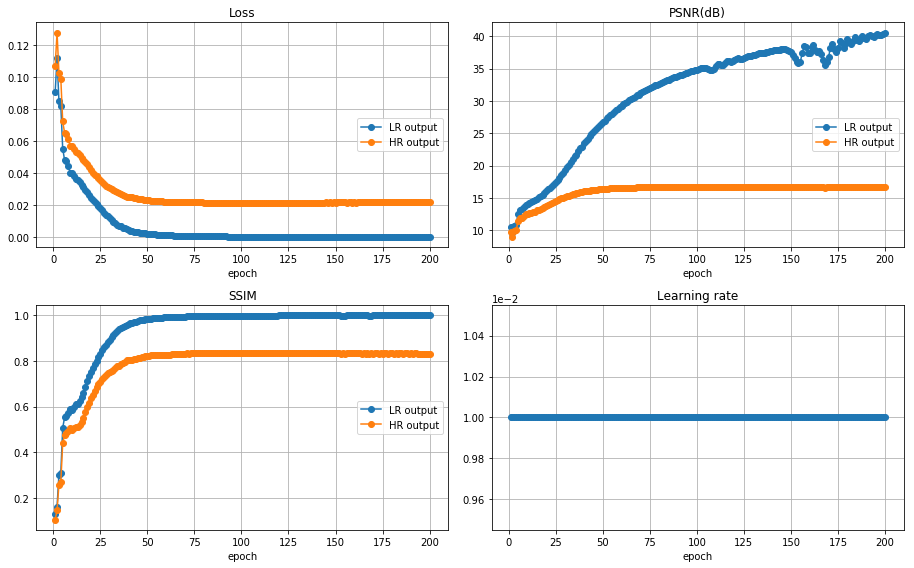

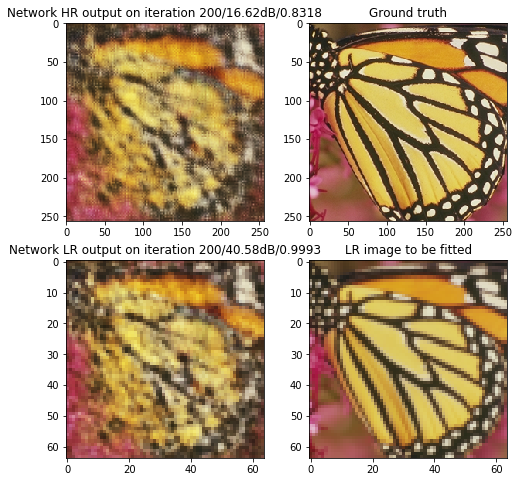


Epoch 00200: saving model to ./DIP_saved_model_Factor4_PerturbedInput_GlorotUni_LeakyRelu_LRFixed0.01/models_on_epoch_end\model_Factor4_PerturbedInput_GlorotUni_LeakyRelu_LRFixed0.01_200_0.0001.hdf5

Epoch 00200: saving model to ./DIP_saved_model_Factor4_PerturbedInput_GlorotUni_LeakyRelu_LRFixed0.01/weights_on_epoch_end\weights_Factor4_PerturbedInput_GlorotUni_LeakyRelu_LRFixed0.01_200_0.0001.h5
Wall time: 26min 48s


In [36]:
%%time

epochs=200
batch_size=1

plot_losses = PlotLosses(figsize=(12.8, 8))

# CheckPoint
model_dir = "./DIP_saved_model" + savename + "/models_on_epoch_end"
weight_dir = "./DIP_saved_model" + savename + "/weights_on_epoch_end"
model_path = 'model' + savename + '_{epoch:02d}' + '_{loss:.4f}' + '.hdf5'
weight_path = 'weights' + savename + '_{epoch:02d}' + '_{loss:.4f}' + '.h5'

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)    
if not os.path.isdir(weight_dir):
    os.makedirs(weight_dir)

checkpoint1 = ModelCheckpoint(os.path.join(model_dir, model_path), monitor='loss', verbose=1, save_best_only=False,
                              save_weights_only=False, mode='min',period=100)
checkpoint2 = ModelCheckpoint(os.path.join(weight_dir, weight_path), monitor='loss', verbose=1, save_best_only=False,
                              save_weights_only=True, mode='min',period=100)

#Learning rate modifier
if lr_decay == True:
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.001)

    # Or modify learning rate by LearningRateScheduler
    def scheduler(epoch):
        # learning rate*0.1 every 10 epochs
        if epoch % 10 == 0 and epoch != 0:
            lr = K.get_value(model.optimizer.lr)
            K.set_value(model.optimizer.lr, lr * 0.1)
            print("lr changed to {}".format(lr * 0.1))
        return K.get_value(model.optimizer.lr)

    reduce_lr = LearningRateScheduler(scheduler)
    
    cb_list = [plot_losses,checkpoint1,checkpoint2,reduce_lr]
else:
    cb_list = [plot_losses,checkpoint1,checkpoint2]

# Fit
plt.ioff()
hist=model.fit(x=get_input(reg_noise_std), y=[y_hr,y_lr], batch_size=batch_size, epochs=epochs, verbose=1, callbacks=cb_list)
plt.close('all')
plt.ion()

#### 3.2.3 Save the training history for further use

In [37]:
import pickle
# Save
hist_dir = "./DIP_saved_model" + savename
hist_path = 'TrainHistory' + savename

if not os.path.isdir(hist_dir):
    os.makedirs(hist_dir)    

with open(os.path.join(hist_dir, hist_path), 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

# Load (optional)
#with open('TrainHistory', 'rb') as file_pi:
#    hist_loaded = pickle.load(file_pi)